In [25]:
import argparse
import numpy as np
from scipy.spatial.transform import Rotation as Rot
import pickle
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from typing import List
import open3d as o3d

from robot_utils.robot_data.pose_data import PoseData
from robot_utils.transform import transform_2_xytheta
from robot_utils.geometry import circle_intersection

from segment_track.segment import Segment
from segment_track.tracker import Tracker

from object_map_registration.object.ellipsoid import Ellipsoid
from object_map_registration.object.object import Object
from object_map_registration.object.pointcloud_object import PointCloudObject
from object_map_registration.register.dist_feature_sim_reg import DistOnlyReg, DistVolReg, DistFeaturePCAReg, DistFeatureSimReg
from object_map_registration.register.dist_reg_with_pruning import DistRegWithPruning, GravityConstraintError
from object_map_registration.register.object_registration import InsufficientAssociationsException
from object_map_registration.utils import object_list_bounds
from open3d.web_visualizer import draw


Loaded 76 and 72 submaps.


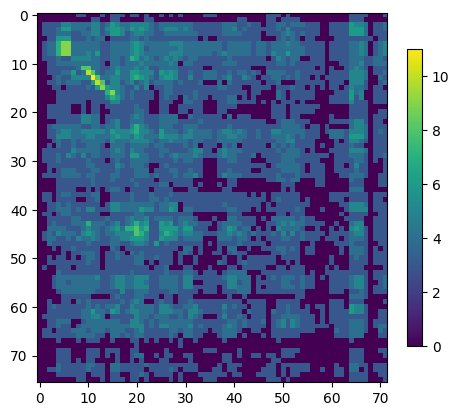

Submap pair (13, 11) contains 45 and 41 objects.
Clipper finds 11 associations.


In [26]:

output_viz_file = '/home/masonbp/results/west_point_2023/segment_align/11_ambiguity/sparkal2_sparkal1/gravity_viz.pkl'
# output_viz_file = '/home/masonbp/results/west_point_2023/segment_align/20_paper/sparkal2_sparkal1_opposite/extentvolgrav.viz.pkl'
pkl_file = open(output_viz_file, 'rb')
submaps_0, submaps_1, associated_objs_mat, robots_nearby_mat, T_ij_mat, T_ij_hat_mat = pickle.load(pkl_file)
pkl_file.close()
print(f'Loaded {len(submaps_0)} and {len(submaps_1)} submaps.')
clipper_num_associations  =  np.zeros((len(submaps_0), len(submaps_1)))*np.nan

max_i = 0
max_j = 0
max_num = 0
for i in range(len(submaps_0)):
  for j in range(len(submaps_1)):
    clipper_num_associations[i, j] =  len(associated_objs_mat[i][j])
    if len(associated_objs_mat[i][j]) > max_num:
      max_num = len(associated_objs_mat[i][j])
      max_i = i
      max_j = j

plt.imshow(
  clipper_num_associations, 
  vmin=0, 
)
plt.colorbar(fraction=0.03, pad=0.04)
plt.show()

# Same dir
idx_0 = max_i
idx_1 = max_j

# Opposite dir


association = associated_objs_mat[idx_0][idx_1]
submap_0 = [PointCloudObject.from_pickle({**data, 'id': 0}) for data in submaps_0[idx_0]]
submap_1 = [PointCloudObject.from_pickle({**data, 'id': 0}) for data in submaps_1[idx_1]]
for obj in submap_0 + submap_1:
  obj.use_bottom_median_as_center()
print(f'Submap pair ({idx_0}, {idx_1}) contains {len(submap_0)} and {len(submap_1)} objects.')
print(f'Clipper finds {len(association)} associations.')

In [27]:
idx_0 = 13
idx_1 = 11
# idx_0 = 20
# idx_1 = 52

sigma = 0.3
epsilon = 0.5
mindist = 0.2
epsilon_volume = 0.2

output_dir = '/home/masonbp/results/west_point_2023/segment_align/11_ambiguity/sparkal2_sparkal1'
methods = ['vol2d', 'vol3d', 'gravity', 'volgrav', 'point2d', 'point3d']
pkl_file = open(output_viz_file, 'rb')
submaps_0, submaps_1, associated_objs_mat, robots_nearby_mat, T_ij_mat, T_ij_hat_mat = pickle.load(pkl_file)
pkl_file.close()

submap_0 = [PointCloudObject.from_pickle({**data, 'id': 0}) for data in submaps_0[idx_0]]
submap_1 = [PointCloudObject.from_pickle({**data, 'id': 0}) for data in submaps_1[idx_1]]

In [28]:
def get_ambiguity_scores(submap_0: List[PointCloudObject], submap_1: List[PointCloudObject], obj_map_reg: DistFeatureSimReg, num_solutions=10):
  solutions = obj_map_reg.mno_clipper(submap_0, submap_1, num_solutions=num_solutions)
  max_score = np.max([solutions[k][1] for k in range(num_solutions)])
  ambiguity_scores = [solutions[k][1] / max_score for k in range(num_solutions)]
  # ambiguity_scores = [solutions[k][1] for k in range(num_solutions)]
  return ambiguity_scores
  

In [29]:
ambiguity_scores = {}
for method in methods:
    if '2' in method:
        dim = 2
    else:
        dim = 3
        
    if method == 'point2d' or method == 'point3d':
        method_name = f'{dim}D Point CLIPPER'
        registration = DistOnlyReg(sigma=sigma, epsilon=epsilon, mindist=mindist, pt_dim=dim)
    elif method == 'gravity':
        method_name = 'Gravity Guided CLIPPER'
        registration = DistOnlyReg(sigma=sigma, mindist=mindist, epsilon=epsilon, use_gravity=True)
    elif method == 'vol2d' or method == 'vol3d':
        method_name = f'{dim}D Volume-based Registration'
        registration = DistVolReg(sigma=sigma, epsilon=epsilon, mindist=mindist, pt_dim=dim, volume_epsilon=epsilon_volume)
    elif method == 'volgrav':
        method_name = f'Gravity Guided Volume-based Registration'
        registration = DistVolReg(sigma=sigma, epsilon=epsilon, mindist=mindist, use_gravity=True, volume_epsilon=epsilon_volume)
    elif method == 'prunevol':
        method_name = f'{dim}D Volume-based Pruning'
        registration = DistRegWithPruning(sigma=sigma, epsilon=epsilon, mindist=mindist, dim=dim, volume_epsilon=epsilon_volume, use_gravity=False)
    elif method == 'prunevolgrav':
        method_name = f'Gravity Filtered Volume-based Pruning'
        registration = DistRegWithPruning(sigma=sigma, epsilon=epsilon, mindist=mindist, dim=dim, volume_epsilon=epsilon_volume, use_gravity=True)
    elif method == 'prunegrav':
        method_name = f'Gravity Filtered Pruning'
        registration = DistRegWithPruning(sigma=sigma, epsilon=epsilon, mindist=mindist, dim=dim, use_gravity=True)
    elif method == 'distfeatpca':
        method_name = f'Gravity Constrained PCA feature-based Registration (eps_pca={epsilon_pca})'
        registration = DistFeaturePCAReg(sigma=sigma, epsilon=epsilon, mindist=mindist, pca_epsilon=epsilon_pca, pt_dim=dim, use_gravity=True)
    else:
        assert False, "Invalid method"
        
    ambiguity_scores[method] = get_ambiguity_scores(submap_0, submap_1, registration, num_solutions=10)

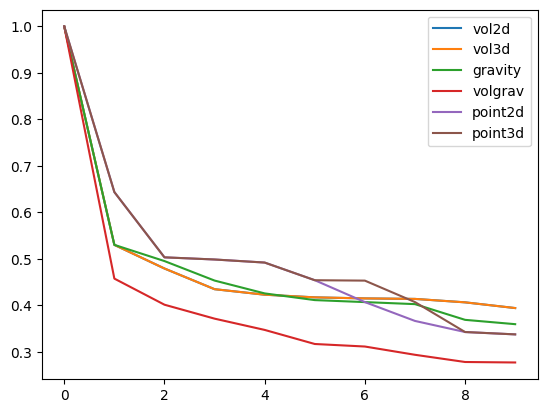

In [30]:
fig, ax = plt.subplots()
for method in methods:
    ax.plot(np.sort(ambiguity_scores[method])[::-1], '-', label=method)
ax.legend()